#### EDA of the Pull Request Data between January 2018 and December 2023

Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
from collections import defaultdict
sns.set(style="whitegrid")
%matplotlib inline

Section 1: Defining File Paths


In [2]:
COVID_PHASES = {
    "pre": ("2018-01-01", "2020-01-29"),
    "during": ("2020-01-30", "2023-05-05"),
    "post": ("2023-05-06", "2023-12-31")
}

REPOS = {
    "scikit-learn": "../data/raw/scikit-learn/scikit-learn_prs_2018_2023.csv",
    "pytorch": "../data/raw/pytorch/pytorch_prs_2018_2023.csv",
    "kubernetes": "../data/raw/kubernetes/kubernetes_prs_2018_2023.csv",
    "apache-spark": "../data/raw/apache/apache_spark_prs_2018_2023.csv"
}

KNOWN_BOTS = {
    "dependabot", "appveyorbot", "bors", "codecov", "coveralls", "circleci", "travis-ci",
    "github-actions", "jenkins", "azure-pipelines", "humbug", "neco-bot", "pyup-bot",
    "automerge", "rebase-bot", "auto-merge", "ci-bot", "codecov-commenter", "scikit-learn-bot", "pytorchupdatebot"
}

Section 1.1: Inspecting Raw Data

In [3]:
# Basic structure overview for each repository
for repo, path in REPOS.items():
    print(f"\n{'='*40}\nRepository: {repo}\n{'='*40}")
    df = pd.read_csv(path, parse_dates=["created_at", "closed_at", "merged_at"])
    print("\nColumns:")
    print(df.columns.tolist())
    
    print("\nData Types:")
    print(df.dtypes)
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    print("\nSample Rows:")


Repository: scikit-learn

Columns:
['pr_number', 'title', 'state', 'created_at', 'closed_at', 'merged_at', 'author', 'merged_by', 'assignees', 'reviewers', 'commit_authors', 'comment_authors', 'review_comment_authors']

Data Types:
pr_number                               int64
title                                  object
state                                  object
created_at                datetime64[ns, UTC]
closed_at                 datetime64[ns, UTC]
merged_at                 datetime64[ns, UTC]
author                                 object
merged_by                             float64
assignees                              object
reviewers                              object
commit_authors                         object
comment_authors                        object
review_comment_authors                 object
dtype: object

Missing Values:
pr_number                     0
title                         0
state                         0
created_at                    0
closed_at 

Section 2: Defining Helper Functions

In [4]:
def assign_covid_phase(date):
    if pd.notnull(date):
        if hasattr(date, "tzinfo") and date.tzinfo is not None:
            date = date.tz_convert(None)
    for phase, (start, end) in COVID_PHASES.items():
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return phase
    return None

def load_and_process_repo(repo_name, file_path):
    df = pd.read_csv(file_path, parse_dates=["created_at", "closed_at", "merged_at"])
    for col in ["created_at", "closed_at", "merged_at"]:
        df[col] = df[col].apply(lambda x: x.tz_convert(None) if pd.notnull(x) and hasattr(x, 'tz_convert') else x)
    df["title"].fillna("No Title", inplace=True)
    df["covid_phase"] = df["created_at"].apply(assign_covid_phase)
    df["repo"] = repo_name
    return df

def detect_bots_per_repo(df, repo_name):
    user_counts = Counter()
    user_roles = {}
    list_fields = ["commit_authors", "comment_authors", "review_comment_authors"]

    def parse_field(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
        return x if isinstance(x, list) else []

    for field in list_fields:
        df[field] = df[field].apply(parse_field)

    for _, row in df.iterrows():
        if pd.notnull(row["author"]):
            user_counts[row["author"]] += 1
            user_roles.setdefault(row["author"], set()).add("author")
        for field in list_fields:
            for user in row[field]:
                user_counts[user] += 1
                user_roles.setdefault(user, set()).add(field)

    records = []
    for user, count in user_counts.items():
        roles = list(user_roles[user])
        u_lower = user.lower()
        is_known = u_lower in KNOWN_BOTS
        only_comments = set(roles).issubset({"comment_authors", "review_comment_authors"})
        high_volume = count > 500
        suspected = is_known or only_comments or high_volume
        records.append({
            "repository": repo_name,
            "username": user,
            "mention_count": count,
            "roles": roles,
            "is_known_bot": is_known,
            "only_comments": only_comments,
            "high_volume": high_volume,
            "suspected_bot": suspected
        })

    bots_df = pd.DataFrame(records)
    suspected_bots = set(bots_df[bots_df["suspected_bot"]]["username"])

    df["author"] = df["author"].apply(lambda x: None if x in suspected_bots else x)
    for col in list_fields:
        df[col] = df[col].apply(lambda lst: [u for u in lst if u not in suspected_bots])

    return df, bots_df

def extract_contributors(row):
    contributors = set()
    for col in ["author", "merged_by", "assignees", "reviewers", "commit_authors", "comment_authors", "review_comment_authors"]:
        val = row[col]
        if isinstance(val, list):
            contributors.update(val)
        elif pd.notnull(val):
            contributors.add(val)
    return list(contributors)

Section 3: PR Dataset Loading and Cleaning

In [5]:
repo_data = {}

for repo, path in REPOS.items():
    df = load_and_process_repo(repo, path)
    df_cleaned, bots = detect_bots_per_repo(df, repo)
    df_cleaned["all_contributors"] = df_cleaned.apply(extract_contributors, axis=1)
    df_cleaned["all_contributors"] = df_cleaned["all_contributors"].apply(lambda x: [c for c in x if c != "[]"])
    repo_data[repo] = {
        "cleaned_df": df_cleaned,
        "bots": bots
    }

Section 4: Summary Statistics

In [6]:
summary_rows = []

for repo, content in repo_data.items():
    df = content["cleaned_df"]
    bots = content["bots"]
    df_exploded = df.explode("all_contributors")
    df_exploded = df_exploded[df_exploded["all_contributors"].apply(lambda x: isinstance(x, str) and x.strip() != "")]

    pr_counts = df["covid_phase"].value_counts().to_dict()
    contributor_counts = df_exploded.groupby("covid_phase")["all_contributors"].nunique().to_dict()
    bot_count = bots["suspected_bot"].sum()

    summary_rows.append({
        "repository": repo,
        "total_prs": len(df),
        "total_contributors": df_exploded["all_contributors"].nunique(),
        "bots_detected": bot_count,
        "prs_pre": pr_counts.get("pre", 0),
        "prs_during": pr_counts.get("during", 0),
        "prs_post": pr_counts.get("post", 0),
        "contributors_pre": contributor_counts.get("pre", 0),
        "contributors_during": contributor_counts.get("during", 0),
        "contributors_post": contributor_counts.get("post", 0),
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

,repository,total_prs,total_contributors,bots_detected,prs_pre,prs_during,prs_post,contributors_pre,contributors_during,contributors_post
0,scikit-learn,10766,2808,446,3436,6211,1085,1143,1633,299
1,pytorch,75414,13119,1122,18264,46773,10265,3095,8650,2798
2,kubernetes,43416,28788,1706,19803,20341,3213,14112,15566,3664
3,apache-spark,24387,2114,795,7229,13654,3475,955,1238,444


Section 5: PR Volume Over Time

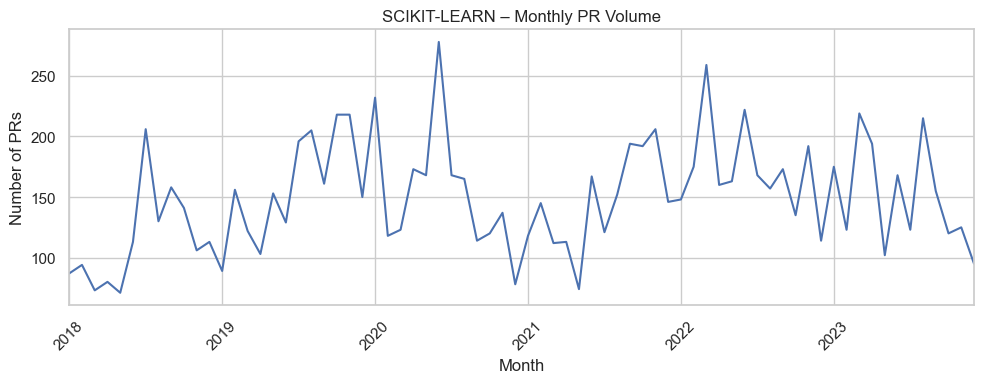

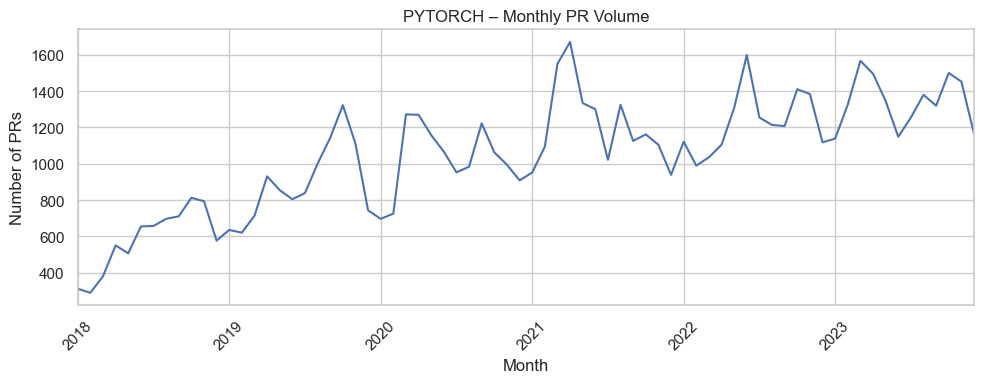

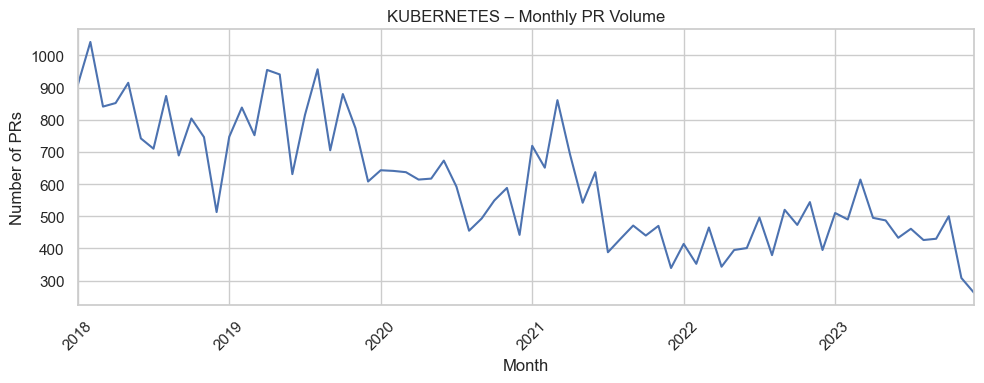

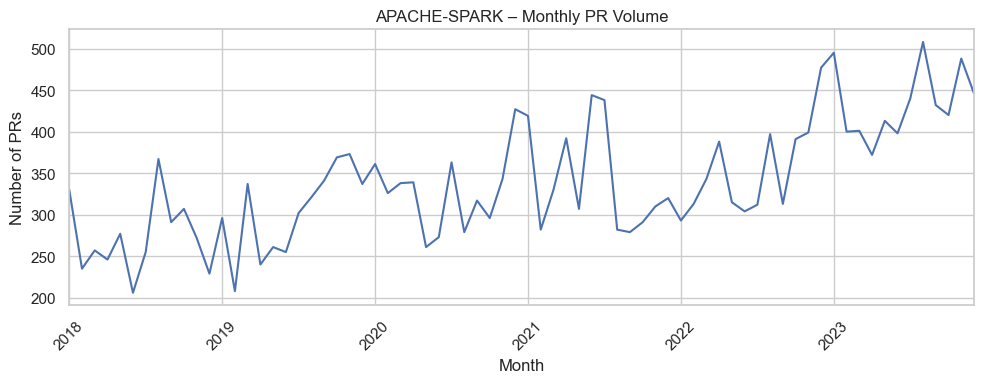

In [7]:
for repo, content in repo_data.items():
    df = content["cleaned_df"]
    df["month"] = df["created_at"].dt.to_period("M")
    monthly = df.groupby("month")["pr_number"].count()
    monthly.plot(figsize=(10, 4), title=f"{repo.upper()} – Monthly PR Volume")
    plt.ylabel("Number of PRs")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Section 6: Contributor Retention Across Phases

In [8]:
overlap_summary = []

for repo, content in repo_data.items():
    df = content["cleaned_df"]
    df_exploded = df.explode("all_contributors")
    df_exploded = df_exploded[df_exploded["all_contributors"].apply(lambda x: isinstance(x, str) and x.strip() != "")]

    pre = set(df_exploded[df_exploded["covid_phase"] == "pre"]["all_contributors"])
    during = set(df_exploded[df_exploded["covid_phase"] == "during"]["all_contributors"])
    post = set(df_exploded[df_exploded["covid_phase"] == "post"]["all_contributors"])

    overlap_summary.append({
        "repository": repo,
        "pre_during_overlap": len(pre & during),
        "during_post_overlap": len(during & post),
        "pre_post_overlap": len(pre & post),
        "pre_total": len(pre),
        "during_total": len(during),
        "post_total": len(post),
    })

overlap_df = pd.DataFrame(overlap_summary)
overlap_df["pre_during_%"] = (overlap_df["pre_during_overlap"] / overlap_df["pre_total"] * 100).round(2)
overlap_df["during_post_%"] = (overlap_df["during_post_overlap"] / overlap_df["during_total"] * 100).round(2)
overlap_df["pre_post_%"] = (overlap_df["pre_post_overlap"] / overlap_df["pre_total"] * 100).round(2)

print("Contributor Overlap Across Phases:")
display(overlap_df)


Contributor Overlap Across Phases:


,repository,pre_during_overlap,during_post_overlap,pre_post_overlap,pre_total,during_total,post_total,pre_during_%,during_post_%,pre_post_%
0,scikit-learn,191,77,36,1143,1633,299,16.71,4.72,3.15
1,pytorch,643,776,122,3095,8650,2798,20.78,8.97,3.94
2,kubernetes,3016,1516,647,14112,15566,3664,21.37,9.74,4.58
3,apache-spark,275,243,85,955,1238,444,28.80,19.63,8.90


Section 7: Save Cleaned Data

In [9]:
import os
os.makedirs("../data/processed", exist_ok=True)

for repo, content in repo_data.items():
    cleaned_path = f"../data/processed/cleaned/{repo.replace('-', '_')}_cleaned.csv"
    bot_path = f"../data/processed/bots/{repo.replace('-', '_')}_bots.csv"
    content["cleaned_df"].to_csv(cleaned_path, index=False)
    content["bots"].to_csv(bot_path, index=False)
    print(f"Saved cleaned data for {repo} to: {cleaned_path}")


Saved cleaned data for scikit-learn to: ../data/processed/cleaned/scikit_learn_cleaned.csv
Saved cleaned data for pytorch to: ../data/processed/cleaned/pytorch_cleaned.csv
Saved cleaned data for kubernetes to: ../data/processed/cleaned/kubernetes_cleaned.csv
Saved cleaned data for apache-spark to: ../data/processed/cleaned/apache_spark_cleaned.csv


Section 8: Cleaned Dataset Summary Table

In [10]:
summary_rows = []

for repo, content in repo_data.items():
    df = content["cleaned_df"]
    bots = content["bots"]
    df_exploded = df.explode("all_contributors")
    df_exploded = df_exploded[df_exploded["all_contributors"].apply(lambda x: isinstance(x, str) and x.strip() != "")]

    pr_counts = df["covid_phase"].value_counts().to_dict()
    contributor_counts = df_exploded.groupby("covid_phase")["all_contributors"].nunique().to_dict()
    bot_count = bots["suspected_bot"].sum()
    bot_mentions = bots["mention_count"].sum()

    summary_rows.append({
        "repository": repo,
        "total_prs": len(df),
        "total_contributors": df_exploded["all_contributors"].nunique(),
        "bots_detected": bot_count,
        "bot_mentions": bot_mentions,
        "prs_pre": pr_counts.get("pre", 0),
        "prs_during": pr_counts.get("during", 0),
        "prs_post": pr_counts.get("post", 0),
        "contributors_pre": contributor_counts.get("pre", 0),
        "contributors_during": contributor_counts.get("during", 0),
        "contributors_post": contributor_counts.get("post", 0),
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

,repository,total_prs,total_contributors,bots_detected,bot_mentions,prs_pre,prs_during,prs_post,contributors_pre,contributors_during,contributors_post
0,scikit-learn,10766,2808,446,43249,3436,6211,1085,1143,1633,299
1,pytorch,75414,13119,1122,320965,18264,46773,10265,3095,8650,2798
2,kubernetes,43416,28788,1706,283037,19803,20341,3213,14112,15566,3664
3,apache-spark,24387,2114,795,134476,7229,13654,3475,955,1238,444


Section 9: Contributor Overlap Across Phases

In [11]:
overlap_summary = []

for repo, content in repo_data.items():
    df = content["cleaned_df"]
    df_exploded = df.explode("all_contributors")
    df_exploded = df_exploded[df_exploded["all_contributors"].apply(lambda x: isinstance(x, str) and x.strip() != "")]

    pre = set(df_exploded[df_exploded["covid_phase"] == "pre"]["all_contributors"])
    during = set(df_exploded[df_exploded["covid_phase"] == "during"]["all_contributors"])
    post = set(df_exploded[df_exploded["covid_phase"] == "post"]["all_contributors"])

    overlap_summary.append({
        "repository": repo,
        "pre_during_%": round(len(pre & during) / len(pre) * 100 if pre else 0, 1),
        "during_post_%": round(len(during & post) / len(during) * 100 if during else 0, 1),
        "pre_post_%": round(len(pre & post) / len(pre) * 100 if pre else 0, 1)
    })

overlap_df = pd.DataFrame(overlap_summary)
display(overlap_df)

,repository,pre_during_%,during_post_%,pre_post_%
0,scikit-learn,16.7,4.7,3.1
1,pytorch,20.8,9.0,3.9
2,kubernetes,21.4,9.7,4.6
3,apache-spark,28.8,19.6,8.9


Section 10: Phase-Level and Contributor Counts

In [12]:
phase_columns = ["repository", "prs_pre", "prs_during", "prs_post",
                 "contributors_pre", "contributors_during", "contributors_post"]
display(summary_df[phase_columns])

,repository,prs_pre,prs_during,prs_post,contributors_pre,contributors_during,contributors_post
0,scikit-learn,3436,6211,1085,1143,1633,299
1,pytorch,18264,46773,10265,3095,8650,2798
2,kubernetes,19803,20341,3213,14112,15566,3664
3,apache-spark,7229,13654,3475,955,1238,444


Section 11: Contributor Engagement Distribution

In [13]:
engagement_summary = []

for repo, content in repo_data.items():
    df = content["cleaned_df"]
    pr_counts = df["author"].dropna().value_counts()
    total = pr_counts.shape[0]
    one_time = (pr_counts == 1).sum()
    five_plus = (pr_counts >= 5).sum()

    engagement_summary.append({
        "repository": repo,
        "total": total,
        "one_time": one_time,
        "five_plus": five_plus
    })

engagement_df = pd.DataFrame(engagement_summary)
display(engagement_df)

,repository,total,one_time,five_plus
0,scikit-learn,2722,1751,218
1,pytorch,4152,2293,844
2,kubernetes,4421,2161,1073
3,apache-spark,1909,1007,399
